# Training and Tuning Notebook

In [1]:
import sys
sys.path.insert(0, 'src')

import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from data_preprocessing import *
from model import *
from train import *
from utils import *

## GPU and Mixed Precision Setup

In [2]:
gpu_setup()
mixed_precision_setup()

Some of your GPUs may run slowly with dtype policy mixed_float16 because they do not all have compute capability of at least 7.0. Your GPUs:
  Tesla V100S-PCIE-32GB, compute capability 7.0
  Tesla V100-PCIE-32GB, compute capability 7.0
  Tesla P100-PCIE-16GB, compute capability 6.0 (x2)
See https://developer.nvidia.com/cuda-gpus for a list of GPUs and their compute capabilities.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [3]:
data_folder = 'data'
dataset = 'lung_ct_dataset'
train_folder = 'train'
test_folder = 'test'
train_label = 'train_label.csv'

## Image Enhancement Visualisation

1. Visualise enhanced images with varying hyperparameters.
2. Edit hyperparameters in `image_enhancement.py`.
3. Run `bash prepare_dataset.sh` to enhance images and re-generate the tensorflow dataset.

(-0.5, 1535.5, 511.5, -0.5)

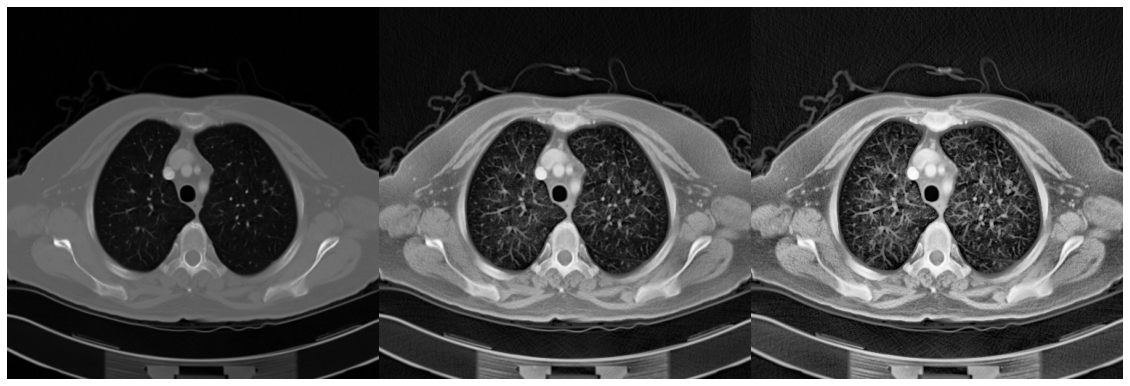

In [4]:
from image_enhancement import *


img_path = os.path.join('nus-cs5242', 'train_image', 'train_image', '851.png')
img = cv.imread(img_path)
n_img = hist_norm(img)
clahe_img1 = clahe(img, clipLimit=4, tileGridSize=(8, 8))
clahe_img2 = clahe(img, clipLimit=8, tileGridSize=(8, 8))
# n_clahe_img = clahe(n_img, clipLimit=clip, tileGridSize=tile_size)

combined_imgs = np.hstack((img, clahe_img1, clahe_img2))
plt.figure(figsize=(20, 20))
plt.imshow(combined_imgs)
plt.axis('off')

# Single Model

## Tune Single Model Parameters

In [5]:
SEED = 0

experiment_name = 'MobileNetV2'
result_save_path = experiment_name + '_' + 'submission.csv'
model_params = {
    'model_type': 'MobileNetV2',
    'head_type': 'standard',
    'image_shape': (512, 512, 3),
    'num_classes': 3,
}
base_hyperparams = {
    'train_batch_size': 64,
    'valid_batch_size': 64,
    'test_batch_size': 64,
    'num_epochs': 5,
    'learning_rate': 1e-4,
    'dropout': 0.2
}
fine_hyperparams = {
    'num_epochs': 10,
    'learning_rate': 1e-5,
    'num_unfreeze': 10,
}

## Load Dataset

In [6]:
import tensorflow_datasets as tfds


tf.random.set_seed(SEED)

train_folds = tfds.load(
    name=dataset, 
    split=[f'train[:{k}%]+train[{k+10}%:]' for k in range(0, 100, 20)],
    download=False, 
    shuffle_files=False, 
    as_supervised=True,
    data_dir=data_folder
)
valid_folds = tfds.load(
    name=dataset, 
    split=[f'train[{k}%:{k+10}%]' for k in range(0, 100, 20)],
    download=False, 
    shuffle_files=False, 
    as_supervised=True,
    data_dir=data_folder
)
test_ds_raw, test_info_raw = tfds.load(
    name=dataset, 
    split='test', 
    download=False, 
    shuffle_files=False, 
    as_supervised=False, 
    with_info=True,
    data_dir=data_folder
)
img_ids = tfds.as_dataframe(test_ds_raw, test_info_raw)

train_folds = [ preprocess(ds, model_params, batch_size=base_hyperparams['train_batch_size'], ds_type='train') for ds in train_folds ]
valid_folds = [ preprocess(ds, model_params, batch_size=base_hyperparams['valid_batch_size'], ds_type='valid') for ds in valid_folds ]
test_ds = preprocess(test_ds_raw, model_params, batch_size=base_hyperparams['test_batch_size'], ds_type='test')

In [7]:
train_valid_df = pd.read_csv(os.path.join('data', 'processed', train_label))
train_ds = train_folds[0]
valid_ds = valid_folds[0]

print(f'Number of train batches: {train_ds.cardinality()}')
print(f'Number of valid batches: {valid_ds.cardinality()}')
print(f'Number of test batches: {test_ds.cardinality()}')

Number of train batches: 17
Number of valid batches: 2
Number of test batches: 5


## K-Fold Cross Validation

Evaluate model performance.

In [18]:
from tensorboard.plugins.hparams import api as hp


# model_param
MODEL_HP_MODEL_TYPE = hp.HParam('model_type', hp.Discrete(['Xception', 'MobileNetV2', 'ResNet152V2']))
MODEL_HP_HEAD_TYPE = hp.HParam('head_type', hp.Discrete(['standard', 'adaptive']))

# base_hparam
BASE_HP_NUM_EPOCHS = hp.HParam('base_num_epochs', hp.Discrete([100, 200, 300]))
BASE_HP_LEARNING_RATE = hp.HParam('base_learning_rate', hp.RealInterval(1e-4, 1e-3))
BASE_HP_DROPOUT = hp.HParam('dropout', hp.RealInterval(0.2, 0.7))

# fine_param
FINE_HP_NUM_EPOCHS = hp.HParam('fine_num_epochs', hp.Discrete([50, 100, 150]))
FINE_HP_LEARNING_RATE = hp.HParam('fine_learning_rate', hp.RealInterval(1e-5, 1e-4))
FINE_HP_NUM_UNFREEZE = hp.HParam('num_unfreeze', hp.IntInterval(10, 100))

METRIC_AVERAGE_TRAIN_LOSS = 'average train loss'
METRIC_AVERAGE_VALID_LOSS = 'average valid loss'
METRIC_AVERAGE_TRAIN_ACCURACY = 'average train accuracy'
METRIC_AVERAGE_VALID_ACCURACY = 'average valid accuracy'

HPARAMS = [
    MODEL_HP_MODEL_TYPE,
    MODEL_HP_HEAD_TYPE,
    BASE_HP_NUM_EPOCHS,
    BASE_HP_LEARNING_RATE,
    BASE_HP_DROPOUT,
    FINE_HP_NUM_EPOCHS,
    FINE_HP_LEARNING_RATE,
    FINE_HP_NUM_UNFREEZE,
]
METRICS = [
    hp.Metric(METRIC_AVERAGE_TRAIN_LOSS, group='train', display_name='average train loss'),
    hp.Metric(METRIC_AVERAGE_TRAIN_ACCURACY, group='train', display_name='average train accuracy'),
    hp.Metric(METRIC_AVERAGE_VALID_LOSS, group='validation', display_name='average valid loss'),
    hp.Metric(METRIC_AVERAGE_VALID_ACCURACY, group='validation', display_name='average valid accuracy'),
]

with tf.summary.create_file_writer('logs/hparam_tuning').as_default():
    hp.hparams_config(
        hparams=HPARAMS,
        metrics=METRICS,
    )

def run(experiment_name, train_folds, valid_folds, model_params, base_hyperparams, fine_hyperparams, hparams):
    with tf.summary.create_file_writer('logs/hparam_tuning/' + experiment_name).as_default():
        hp.hparams(hparams)
        avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc = cross_validate(experiment_name, train_folds, valid_folds, model_params, base_hyperparams, fine_hyperparams, hparams)    

        tf.summary.scalar(METRIC_AVERAGE_TRAIN_LOSS, avg_train_loss, step=1)
        tf.summary.scalar(METRIC_AVERAGE_TRAIN_ACCURACY, avg_train_acc, step=1)
        tf.summary.scalar(METRIC_AVERAGE_VALID_LOSS, avg_valid_loss, step=1)
        tf.summary.scalar(METRIC_AVERAGE_VALID_ACCURACY, avg_valid_acc, step=1)


0.4764651396693541

In [8]:
tf.random.set_seed(SEED)

session_num = 0
for model_type in MODEL_HP_MODEL_TYPE.domain.values:
    for head_type in MODEL_HP_HEAD_TYPE.domain.values:
        for base_num_epochs in BASE_HP_NUM_EPOCHS.domain.values:
            for fine_num_epochs in FINE_HP_NUM_EPOCHS.domain.values:
                base_lr = BASE_HP_LEARNING_RATE.domain.sample_uniform()
                base_dropout = BASE_HP_DROPOUT.domain.sample_uniform()
                fine_lr = FINE_HP_LEARNING_RATE.domain.sample_uniform()
                fine_num_unfreeze = FINE_HP_NUM_UNFREEZE.domain.sample_uniform()

                hparams = {
                    MODEL_HP_MODEL_TYPE: model_type,
                    MODEL_HP_HEAD_TYPE: head_type,
                    BASE_HP_NUM_EPOCHS: base_num_epochs,
                    BASE_HP_LEARNING_RATE: base_lr,
                    BASE_HP_DROPOUT: base_dropout,
                    FINE_HP_NUM_EPOCHS: fine_num_epochs,
                    FINE_HP_LEARNING_RATE: fine_lr,
                    FINE_HP_NUM_UNFREEZE: fine_num_unfreeze,
                }
                model_params = {
                    'model_type': model_type,
                    'head_type': head_type,
                    'image_shape': (512, 512, 3),
                    'num_classes': 3,
                }
                base_hyperparams = {
                    'train_batch_size': 64,
                    'valid_batch_size': 64,
                    'test_batch_size': 64,
                    'num_epochs': base_num_epochs,
                    'learning_rate': base_lr,
                    'dropout': base_dropout
                }
                fine_hyperparams = {
                    'num_epochs': fine_num_epochs,
                    'learning_rate': fine_lr,
                    'num_unfreeze': fine_num_unfreeze,
                }
                experiment_name = 'Run_{:04d}_{}'.format(session_num, model_params['model_type'])

                print('--- Starting Trial: {}\n'.format(experiment_name))
                print({h.name: hparams[h] for h in hparams})

                run(experiment_name, train_folds, valid_folds, model_params, base_hyperparams, fine_hyperparams, hparams)
                session_num += 1

--- Starting Trial: Run_0000_MobileNetV2

{'model_type': 'MobileNetV2', 'fine_tune_at': 20, 'dropout': 0.2}
# -------------------- Run_0000_MobileNetV2: 1-fold -------------------- #


 1/17 [>.............................] - ETA: 0s - loss: 1.4731 - accuracy: 0.2031WARNING:tensorflow:From /home/zongsien/MedicalImageClassifier/env/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.


Instructions for updating:
use `tf.profiler.experimental.stop` instead.


17/17 [==============================] - 4s 234ms/step - loss: 1.2872 - accuracy: 0.2729 - val_loss: 1.1388 - val_accuracy: 0.3879
Number of layers in the base model:  155
Epoch 2/2
 2/17 [==>...........................] - ETA: 9s - loss: 1.2014 - accuracy: 0.3359WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2003s vs `on_train_batch_end` time: 1.0476s). Check your callbacks.


17/17 [==============================] - 6s 354ms/step - loss: 0.9617 - accuracy: 0.5382 - val_loss: 0.8521 - val_accuracy: 0.6638
Run_0000_MobileNetV2 | Train Loss: 0.9617395997047424 | Train Accuracy: 0.5381679534912109 | Validation Loss: 0.8520523309707642 | Validation Accuracy: 0.6637930870056152

Avg Train Loss: 0.9617395997047424 | Avg Train Accuracy: 0.5381679534912109 | Avg Validation Loss: 0.8520523309707642 | Avg Validation Accuracy: 0.6637930870056152

--- Starting Trial: Run_0001_MobileNetV2

{'model_type': 'MobileNetV2', 'fine_tune_at': 20, 'dropout': 0.7}
# -------------------- Run_0001_MobileNetV2: 1-fold -------------------- #


 2/17 [==>...........................] - ETA: 13s - loss: 1.4262 - accuracy: 0.3828WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.5476s vs `on_train_batch_end` time: 1.2307s). Check your callbacks.


17/17 [==============================] - 5s 307ms/step - loss: 1.4652 - accuracy: 0.3426 - val_loss: 1.2765 - val_accuracy: 0.3879
Number of layers in the base model:  155
Epoch 2/2
 2/17 [==>...........................] - ETA: 16s - loss: 1.4013 - accuracy: 0.3828WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2118s vs `on_train_batch_end` time: 2.0243s). Check your callbacks.


17/17 [==============================] - 6s 372ms/step - loss: 1.1408 - accuracy: 0.4580 - val_loss: 0.9311 - val_accuracy: 0.6293
Run_0001_MobileNetV2 | Train Loss: 1.1407694816589355 | Train Accuracy: 0.4580152630805969 | Validation Loss: 0.9310868978500366 | Validation Accuracy: 0.6293103694915771

Avg Train Loss: 1.1407694816589355 | Avg Train Accuracy: 0.4580152630805969 | Avg Validation Loss: 0.9310868978500366 | Avg Validation Accuracy: 0.6293103694915771

--- Starting Trial: Run_0002_MobileNetV2

{'model_type': 'MobileNetV2', 'fine_tune_at': 80, 'dropout': 0.2}
# -------------------- Run_0002_MobileNetV2: 1-fold -------------------- #


 2/17 [==>...........................] - ETA: 7s - loss: 1.3070 - accuracy: 0.2422WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1871s vs `on_train_batch_end` time: 0.8013s). Check your callbacks.


16/17 [===========================>..] - ETA: 0s - loss: 1.2385 - accuracy: 0.3105WARNING:tensorflow:5 out of the last 9 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e44ff1b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 4s 228ms/step - loss: 1.2388 - accuracy: 0.3111 - val_loss: 1.1569 - val_accuracy: 0.4224
Number of layers in the base model:  155
Epoch 2/2
 2/17 [==>...........................] - ETA: 14s - loss: 1.1254 - accuracy: 0.4219WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2472s vs `on_train_batch_end` time: 1.6220s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 0.9368 - accuracy: 0.5506WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e44ff5b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 5s 304ms/step - loss: 0.9368 - accuracy: 0.5506 - val_loss: 0.8001 - val_accuracy: 0.6983
Run_0002_MobileNetV2 | Train Loss: 0.9367503523826599 | Train Accuracy: 0.5505725145339966 | Validation Loss: 0.8001019954681396 | Validation Accuracy: 0.6982758641242981

Avg Train Loss: 0.9367503523826599 | Avg Train Accuracy: 0.5505725145339966 | Avg Validation Loss: 0.8001019954681396 | Avg Validation Accuracy: 0.6982758641242981

--- Starting Trial: Run_0003_MobileNetV2

{'model_type': 'MobileNetV2', 'fine_tune_at': 80, 'dropout': 0.7}
# -------------------- Run_0003_MobileNetV2: 1-fold -------------------- #


 2/17 [==>...........................] - ETA: 13s - loss: 1.6775 - accuracy: 0.3047WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.5260s vs `on_train_batch_end` time: 1.2288s). Check your callbacks.


16/17 [===========================>..] - ETA: 0s - loss: 1.5675 - accuracy: 0.3154WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b7c722560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 5s 276ms/step - loss: 1.5703 - accuracy: 0.3120 - val_loss: 1.1322 - val_accuracy: 0.4569
Number of layers in the base model:  155
Epoch 2/2
 2/17 [==>...........................] - ETA: 12s - loss: 1.4747 - accuracy: 0.3281WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1568s vs `on_train_batch_end` time: 1.4969s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.1622 - accuracy: 0.4437WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e4bf66b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 5s 290ms/step - loss: 1.1622 - accuracy: 0.4437 - val_loss: 0.9128 - val_accuracy: 0.7155
Run_0003_MobileNetV2 | Train Loss: 1.1622049808502197 | Train Accuracy: 0.4437022805213928 | Validation Loss: 0.9127984046936035 | Validation Accuracy: 0.7155172228813171

Avg Train Loss: 1.1622049808502197 | Avg Train Accuracy: 0.4437022805213928 | Avg Validation Loss: 0.9127984046936035 | Avg Validation Accuracy: 0.7155172228813171

--- Starting Trial: Run_0004_MobileNetV2

{'model_type': 'MobileNetV2', 'fine_tune_at': 100, 'dropout': 0.2}
# -------------------- Run_0004_MobileNetV2: 1-fold -------------------- #


 2/17 [==>...........................] - ETA: 11s - loss: 1.2182 - accuracy: 0.3203WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2763s vs `on_train_batch_end` time: 1.2301s). Check your callbacks.


16/17 [===========================>..] - ETA: 0s - loss: 1.1667 - accuracy: 0.3564WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e497cf560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 4s 252ms/step - loss: 1.1643 - accuracy: 0.3607 - val_loss: 1.1092 - val_accuracy: 0.3966
Number of layers in the base model:  155
Epoch 2/2
 2/17 [==>...........................] - ETA: 12s - loss: 1.1086 - accuracy: 0.4219WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1994s vs `on_train_batch_end` time: 1.4746s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 0.9318 - accuracy: 0.5725WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e5069dcb0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 5s 280ms/step - loss: 0.9318 - accuracy: 0.5725 - val_loss: 0.8118 - val_accuracy: 0.7069
Run_0004_MobileNetV2 | Train Loss: 0.931828498840332 | Train Accuracy: 0.572519063949585 | Validation Loss: 0.811813235282898 | Validation Accuracy: 0.7068965435028076

Avg Train Loss: 0.931828498840332 | Avg Train Accuracy: 0.572519063949585 | Avg Validation Loss: 0.811813235282898 | Avg Validation Accuracy: 0.7068965435028076

--- Starting Trial: Run_0005_MobileNetV2

{'model_type': 'MobileNetV2', 'fine_tune_at': 100, 'dropout': 0.7}
# -------------------- Run_0005_MobileNetV2: 1-fold -------------------- #


 2/17 [==>...........................] - ETA: 12s - loss: 1.5101 - accuracy: 0.3516WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.1268s vs `on_train_batch_end` time: 1.5454s). Check your callbacks.


16/17 [===========================>..] - ETA: 0s - loss: 1.4424 - accuracy: 0.3945WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e5133add0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 5s 277ms/step - loss: 1.4521 - accuracy: 0.3903 - val_loss: 1.2112 - val_accuracy: 0.3707
Number of layers in the base model:  155
Epoch 2/2
 2/17 [==>...........................] - ETA: 13s - loss: 1.3830 - accuracy: 0.3594WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3413s vs `on_train_batch_end` time: 1.4037s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.1379 - accuracy: 0.4408WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e50981a70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 5s 293ms/step - loss: 1.1379 - accuracy: 0.4408 - val_loss: 0.9542 - val_accuracy: 0.6293
Run_0005_MobileNetV2 | Train Loss: 1.137870192527771 | Train Accuracy: 0.4408397078514099 | Validation Loss: 0.9541727900505066 | Validation Accuracy: 0.6293103694915771

Avg Train Loss: 1.137870192527771 | Avg Train Accuracy: 0.4408397078514099 | Avg Validation Loss: 0.9541727900505066 | Avg Validation Accuracy: 0.6293103694915771

--- Starting Trial: Run_0006_ResNet152V2

{'model_type': 'ResNet152V2', 'fine_tune_at': 20, 'dropout': 0.2}
# -------------------- Run_0006_ResNet152V2: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 14s - loss: 1.2661 - accuracy: 0.3281WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3438s vs `on_train_batch_end` time: 1.5790s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.1808 - accuracy: 0.3817WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e51374b00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 10s 586ms/step - loss: 1.1808 - accuracy: 0.3817 - val_loss: 1.1188 - val_accuracy: 0.3966
Number of layers in the base model:  564
Epoch 2/2
 2/17 [==>...........................] - ETA: 25s - loss: 1.1081 - accuracy: 0.4219WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.8208s vs `on_train_batch_end` time: 2.5282s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 0.8212 - accuracy: 0.6746WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e385cb5f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 19s 1s/step - loss: 0.8212 - accuracy: 0.6746 - val_loss: 0.6672 - val_accuracy: 0.7931
Run_0006_ResNet152V2 | Train Loss: 0.8212271928787231 | Train Accuracy: 0.6746183037757874 | Validation Loss: 0.6671732068061829 | Validation Accuracy: 0.7931034564971924

Avg Train Loss: 0.8212271928787231 | Avg Train Accuracy: 0.6746183037757874 | Avg Validation Loss: 0.6671732068061829 | Avg Validation Accuracy: 0.7931034564971924

--- Starting Trial: Run_0007_ResNet152V2

{'model_type': 'ResNet152V2', 'fine_tune_at': 20, 'dropout': 0.7}
# -------------------- Run_0007_ResNet152V2: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 16s - loss: 1.5662 - accuracy: 0.3750WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.6403s vs `on_train_batch_end` time: 1.5793s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.4574 - accuracy: 0.3865WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b20631b90> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 10s 570ms/step - loss: 1.4574 - accuracy: 0.3865 - val_loss: 1.2942 - val_accuracy: 0.3448
Number of layers in the base model:  564
Epoch 2/2
 2/17 [==>...........................] - ETA: 24s - loss: 1.3385 - accuracy: 0.4297WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.8758s vs `on_train_batch_end` time: 2.3738s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.0612 - accuracy: 0.5010WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e491e8560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 18s 1s/step - loss: 1.0612 - accuracy: 0.5010 - val_loss: 0.9024 - val_accuracy: 0.6034
Run_0007_ResNet152V2 | Train Loss: 1.0612025260925293 | Train Accuracy: 0.5009542107582092 | Validation Loss: 0.9023584127426147 | Validation Accuracy: 0.6034482717514038

Avg Train Loss: 1.0612025260925293 | Avg Train Accuracy: 0.5009542107582092 | Avg Validation Loss: 0.9023584127426147 | Avg Validation Accuracy: 0.6034482717514038

--- Starting Trial: Run_0008_ResNet152V2

{'model_type': 'ResNet152V2', 'fine_tune_at': 80, 'dropout': 0.2}
# -------------------- Run_0008_ResNet152V2: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 16s - loss: 1.1674 - accuracy: 0.3828WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3212s vs `on_train_batch_end` time: 1.8602s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.0943 - accuracy: 0.4361WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b202cab00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 10s 610ms/step - loss: 1.0943 - accuracy: 0.4361 - val_loss: 1.0119 - val_accuracy: 0.5776
Number of layers in the base model:  564
Epoch 2/2
 2/17 [==>...........................] - ETA: 22s - loss: 1.0861 - accuracy: 0.4688WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.7228s vs `on_train_batch_end` time: 2.2108s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 0.8033 - accuracy: 0.6813WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b54409a70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 17s 989ms/step - loss: 0.8033 - accuracy: 0.6813 - val_loss: 0.7015 - val_accuracy: 0.7759
Run_0008_ResNet152V2 | Train Loss: 0.8032547831535339 | Train Accuracy: 0.6812977194786072 | Validation Loss: 0.7015187740325928 | Validation Accuracy: 0.7758620977401733

Avg Train Loss: 0.8032547831535339 | Avg Train Accuracy: 0.6812977194786072 | Avg Validation Loss: 0.7015187740325928 | Avg Validation Accuracy: 0.7758620977401733

--- Starting Trial: Run_0009_ResNet152V2

{'model_type': 'ResNet152V2', 'fine_tune_at': 80, 'dropout': 0.7}
# -------------------- Run_0009_ResNet152V2: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 13s - loss: 1.6700 - accuracy: 0.2812WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3091s vs `on_train_batch_end` time: 1.4882s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.4994 - accuracy: 0.3721WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b540b0830> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 9s 540ms/step - loss: 1.4994 - accuracy: 0.3721 - val_loss: 1.0995 - val_accuracy: 0.4310
Number of layers in the base model:  564
Epoch 2/2
 2/17 [==>...........................] - ETA: 22s - loss: 1.5470 - accuracy: 0.3594WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.7609s vs `on_train_batch_end` time: 2.2638s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.0752 - accuracy: 0.4933WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e504b8dd0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 16s 954ms/step - loss: 1.0752 - accuracy: 0.4933 - val_loss: 0.8581 - val_accuracy: 0.6379
Run_0009_ResNet152V2 | Train Loss: 1.0752164125442505 | Train Accuracy: 0.49332061409950256 | Validation Loss: 0.858110785484314 | Validation Accuracy: 0.6379310488700867

Avg Train Loss: 1.0752164125442505 | Avg Train Accuracy: 0.49332061409950256 | Avg Validation Loss: 0.858110785484314 | Avg Validation Accuracy: 0.6379310488700867

--- Starting Trial: Run_0010_ResNet152V2

{'model_type': 'ResNet152V2', 'fine_tune_at': 100, 'dropout': 0.2}
# -------------------- Run_0010_ResNet152V2: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 17s - loss: 1.7837 - accuracy: 0.2656WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3880s vs `on_train_batch_end` time: 1.9584s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.4904 - accuracy: 0.2710WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e32bfb320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 10s 589ms/step - loss: 1.4904 - accuracy: 0.2710 - val_loss: 1.1459 - val_accuracy: 0.3276
Number of layers in the base model:  564
Epoch 2/2
 2/17 [==>...........................] - ETA: 24s - loss: 1.2812 - accuracy: 0.2734WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.9125s vs `on_train_batch_end` time: 2.2948s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 0.9105 - accuracy: 0.5973WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e374277a0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 16s 956ms/step - loss: 0.9105 - accuracy: 0.5973 - val_loss: 0.7463 - val_accuracy: 0.7328
Run_0010_ResNet152V2 | Train Loss: 0.9104731678962708 | Train Accuracy: 0.597328245639801 | Validation Loss: 0.746340274810791 | Validation Accuracy: 0.732758641242981

Avg Train Loss: 0.9104731678962708 | Avg Train Accuracy: 0.597328245639801 | Avg Validation Loss: 0.746340274810791 | Avg Validation Accuracy: 0.732758641242981

--- Starting Trial: Run_0011_ResNet152V2

{'model_type': 'ResNet152V2', 'fine_tune_at': 100, 'dropout': 0.7}
# -------------------- Run_0011_ResNet152V2: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 15s - loss: 1.3771 - accuracy: 0.3750WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3187s vs `on_train_batch_end` time: 1.7154s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.3900 - accuracy: 0.3903WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e44a3da70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 9s 557ms/step - loss: 1.3900 - accuracy: 0.3903 - val_loss: 1.0232 - val_accuracy: 0.4655
Number of layers in the base model:  564
Epoch 2/2
 2/17 [==>...........................] - ETA: 24s - loss: 1.2622 - accuracy: 0.4219WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.7138s vs `on_train_batch_end` time: 2.5144s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.0297 - accuracy: 0.4962WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e29330a70> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 16s 963ms/step - loss: 1.0297 - accuracy: 0.4962 - val_loss: 0.8712 - val_accuracy: 0.6293
Run_0011_ResNet152V2 | Train Loss: 1.0296711921691895 | Train Accuracy: 0.49618321657180786 | Validation Loss: 0.8712063431739807 | Validation Accuracy: 0.6293103694915771

Avg Train Loss: 1.0296711921691895 | Avg Train Accuracy: 0.49618321657180786 | Avg Validation Loss: 0.8712063431739807 | Avg Validation Accuracy: 0.6293103694915771

--- Starting Trial: Run_0012_Xception

{'model_type': 'Xception', 'fine_tune_at': 20, 'dropout': 0.2}
# -------------------- Run_0012_Xception: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 9s - loss: 1.1152 - accuracy: 0.3359WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3056s vs `on_train_batch_end` time: 0.9496s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.0815 - accuracy: 0.3989WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e3e8284d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 9s 526ms/step - loss: 1.0815 - accuracy: 0.3989 - val_loss: 1.0802 - val_accuracy: 0.3707
Number of layers in the base model:  132
Epoch 2/2
 2/17 [==>...........................] - ETA: 10s - loss: 1.0311 - accuracy: 0.4844WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.4951s vs `on_train_batch_end` time: 0.8498s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 0.9717 - accuracy: 0.5095WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e5137e4d0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 11s 640ms/step - loss: 0.9717 - accuracy: 0.5095 - val_loss: 0.9344 - val_accuracy: 0.5345
Run_0012_Xception | Train Loss: 0.9716949462890625 | Train Accuracy: 0.5095419883728027 | Validation Loss: 0.9343504905700684 | Validation Accuracy: 0.5344827771186829

Avg Train Loss: 0.9716949462890625 | Avg Train Accuracy: 0.5095419883728027 | Avg Validation Loss: 0.9343504905700684 | Avg Validation Accuracy: 0.5344827771186829

--- Starting Trial: Run_0013_Xception

{'model_type': 'Xception', 'fine_tune_at': 20, 'dropout': 0.7}
# -------------------- Run_0013_Xception: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 10s - loss: 1.1642 - accuracy: 0.3672WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3674s vs `on_train_batch_end` time: 1.0440s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.1263 - accuracy: 0.3817WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e44861710> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 7s 436ms/step - loss: 1.1263 - accuracy: 0.3817 - val_loss: 1.0791 - val_accuracy: 0.3707
Number of layers in the base model:  132
Epoch 2/2
 2/17 [==>...........................] - ETA: 12s - loss: 1.1136 - accuracy: 0.3750WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.5674s vs `on_train_batch_end` time: 1.1166s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.0426 - accuracy: 0.4647WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e2915fb00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 11s 629ms/step - loss: 1.0426 - accuracy: 0.4647 - val_loss: 0.9927 - val_accuracy: 0.4052
Run_0013_Xception | Train Loss: 1.0425593852996826 | Train Accuracy: 0.46469464898109436 | Validation Loss: 0.9926589727401733 | Validation Accuracy: 0.4051724076271057

Avg Train Loss: 1.0425593852996826 | Avg Train Accuracy: 0.46469464898109436 | Avg Validation Loss: 0.9926589727401733 | Avg Validation Accuracy: 0.4051724076271057

--- Starting Trial: Run_0014_Xception

{'model_type': 'Xception', 'fine_tune_at': 80, 'dropout': 0.2}
# -------------------- Run_0014_Xception: 1-fold -------------------- #
17/17 [==============================] - ETA: 0s - loss: 1.0642 - accuracy: 0.4523WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e26cec9e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a l

17/17 [==============================] - 7s 436ms/step - loss: 1.0642 - accuracy: 0.4523 - val_loss: 1.0899 - val_accuracy: 0.3966
Number of layers in the base model:  132
Epoch 2/2
 2/17 [==>...........................] - ETA: 12s - loss: 1.0259 - accuracy: 0.4922WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3947s vs `on_train_batch_end` time: 1.3150s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 0.9888 - accuracy: 0.5048WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e49721560> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 9s 516ms/step - loss: 0.9888 - accuracy: 0.5048 - val_loss: 0.9916 - val_accuracy: 0.4569
Run_0014_Xception | Train Loss: 0.9888284802436829 | Train Accuracy: 0.5047709941864014 | Validation Loss: 0.991610586643219 | Validation Accuracy: 0.4568965435028076

Avg Train Loss: 0.9888284802436829 | Avg Train Accuracy: 0.5047709941864014 | Avg Validation Loss: 0.991610586643219 | Avg Validation Accuracy: 0.4568965435028076

--- Starting Trial: Run_0015_Xception

{'model_type': 'Xception', 'fine_tune_at': 80, 'dropout': 0.7}
# -------------------- Run_0015_Xception: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 9s - loss: 1.2054 - accuracy: 0.2812WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3302s vs `on_train_batch_end` time: 0.9615s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.1441 - accuracy: 0.3740WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b206bfd40> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 7s 422ms/step - loss: 1.1441 - accuracy: 0.3740 - val_loss: 1.0867 - val_accuracy: 0.3966
Number of layers in the base model:  132
Epoch 2/2
17/17 [==============================] - ETA: 0s - loss: 1.0607 - accuracy: 0.4494WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b20601e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for

17/17 [==============================] - 9s 523ms/step - loss: 1.0607 - accuracy: 0.4494 - val_loss: 1.0462 - val_accuracy: 0.3966
Run_0015_Xception | Train Loss: 1.0606558322906494 | Train Accuracy: 0.4494274854660034 | Validation Loss: 1.0461872816085815 | Validation Accuracy: 0.3965517282485962

Avg Train Loss: 1.0606558322906494 | Avg Train Accuracy: 0.4494274854660034 | Avg Validation Loss: 1.0461872816085815 | Avg Validation Accuracy: 0.3965517282485962

--- Starting Trial: Run_0016_Xception

{'model_type': 'Xception', 'fine_tune_at': 100, 'dropout': 0.2}
# -------------------- Run_0016_Xception: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 9s - loss: 1.0955 - accuracy: 0.4453WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3501s vs `on_train_batch_end` time: 0.8872s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.0674 - accuracy: 0.4618WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b547d0e60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 7s 414ms/step - loss: 1.0674 - accuracy: 0.4618 - val_loss: 1.0639 - val_accuracy: 0.4052
Number of layers in the base model:  132
Epoch 2/2
 2/17 [==>...........................] - ETA: 10s - loss: 1.0157 - accuracy: 0.4922WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.3754s vs `on_train_batch_end` time: 1.0419s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 0.9851 - accuracy: 0.5219WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b20375440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 8s 461ms/step - loss: 0.9851 - accuracy: 0.5219 - val_loss: 0.9688 - val_accuracy: 0.5345
Run_0016_Xception | Train Loss: 0.985069215297699 | Train Accuracy: 0.5219465494155884 | Validation Loss: 0.9687905311584473 | Validation Accuracy: 0.5344827771186829

Avg Train Loss: 0.985069215297699 | Avg Train Accuracy: 0.5219465494155884 | Avg Validation Loss: 0.9687905311584473 | Avg Validation Accuracy: 0.5344827771186829

--- Starting Trial: Run_0017_Xception

{'model_type': 'Xception', 'fine_tune_at': 100, 'dropout': 0.7}
# -------------------- Run_0017_Xception: 1-fold -------------------- #
 2/17 [==>...........................] - ETA: 9s - loss: 1.1819 - accuracy: 0.3203WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.2953s vs `on_train_batch_end` time: 1.0245s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.1454 - accuracy: 0.3473WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2b7c0b3440> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 7s 421ms/step - loss: 1.1454 - accuracy: 0.3473 - val_loss: 1.0811 - val_accuracy: 0.3966
Number of layers in the base model:  132
Epoch 2/2
 2/17 [==>...........................] - ETA: 10s - loss: 1.0831 - accuracy: 0.4609WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.4228s vs `on_train_batch_end` time: 1.0135s). Check your callbacks.


17/17 [==============================] - ETA: 0s - loss: 1.0715 - accuracy: 0.4456WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_test_function.<locals>.test_function at 0x7f2e50bbdf80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


17/17 [==============================] - 8s 467ms/step - loss: 1.0715 - accuracy: 0.4456 - val_loss: 1.0313 - val_accuracy: 0.4224
Run_0017_Xception | Train Loss: 1.0715190172195435 | Train Accuracy: 0.4456106722354889 | Validation Loss: 1.0313249826431274 | Validation Accuracy: 0.42241379618644714

Avg Train Loss: 1.0715190172195435 | Avg Train Accuracy: 0.4456106722354889 | Avg Validation Loss: 1.0313249826431274 | Avg Validation Accuracy: 0.42241379618644714



In [11]:
tf.random.set_seed(SEED)

avg_train_loss, avg_train_acc, avg_valid_loss, avg_valid_acc = cross_validate(experiment_name, train_folds, valid_folds, model_params, base_hyperparams, fine_hyperparams)

# -------------------- MobileNetV2: 1-fold -------------------- #
Epoch 1/5
 1/17 [>.............................] - ETA: 0s - loss: 1.4801 - accuracy: 0.2344WARNING:tensorflow:From /home/zongsien/MedicalImageClassifier/env/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
17/17 [==============================] - 3s 179ms/step - loss: 1.2875 - accuracy: 0.2681 - val_loss: 1.1392 - val_accuracy: 0.3966
Epoch 2/5
17/17 [==============================] - 3s 198ms/step - loss: 1.1594 - accuracy: 0.3817 - val_loss: 1.1450 - val_accuracy: 0.3966
Epoch 3/5
17/17 [==============================] - 3s 200ms/step - loss: 1.0995 - accuracy: 0.4265 - val_loss: 1.0880 - val_accuracy: 0.4224
Epoch 4/5
17/17 [==============================]

## Train and Save Best Model

Train the cross validated model with the best parameters and save the model.

In [8]:
tf.random.set_seed(SEED)

model = feature_extract_and_fine_tune(experiment_name, train_ds, valid_ds, model_params, base_hyperparams, fine_hyperparams)
predicted_labels = evaluate(model, test_ds)
img_ids = tfds.as_dataframe(test_ds_raw, test_info_raw)
save_results(img_ids, predicted_labels, result_save_path)
save_model(model, experiment_name)

Epoch 1/5
 1/17 [>.............................] - ETA: 0s - loss: 1.4113 - accuracy: 0.2188WARNING:tensorflow:From /home/zongsien/MedicalImageClassifier/env/lib/python3.7/site-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
17/17 [==============================] - 4s 208ms/step - loss: 1.2949 - accuracy: 0.2538 - val_loss: 1.1395 - val_accuracy: 0.3879
Epoch 2/5
17/17 [==============================] - 4s 235ms/step - loss: 1.1597 - accuracy: 0.3836 - val_loss: 1.1471 - val_accuracy: 0.3966
Epoch 3/5
17/17 [==============================] - 3s 167ms/step - loss: 1.0883 - accuracy: 0.4552 - val_loss: 1.0877 - val_accuracy: 0.4310
Epoch 4/5
17/17 [==============================] - 3s 198ms/step - loss: 1.0522 - accuracy: 0.4752 - val_loss: 1.0

# Ensemble Model

## Tune Ensemble Model Parameters

In [13]:
SEED = 0

experiment_name = 'Ensemble'
result_save_path = experiment_name + '_' + 'submission.csv'
model_params = {
    'model_names': ['Xception', 'MobileNetV2', 'ResNet152V2'],
    'head_type': 'ensemble',
    'image_shape': (512, 512, 3),
    'num_classes': 3,
}
base_hyperparams = {
    'train_batch_size': 64,
    'valid_batch_size': 64,
    'test_batch_size': 64,
    'num_epochs': 5,
    'learning_rate': 1e-4,
    'hidden_units': 10
}

## Modify dataset

Convert dataset to support multiple models with multiple inputs

In [14]:
tf.random.set_seed(SEED)

train_ds = train_ds.concatenate(valid_ds)  # train on entire dataset

train_ds = preprocess_ensemble(train_ds, model_params)
valid_ds = preprocess_ensemble(valid_ds, model_params)
test_ds = preprocess_ensemble(test_ds, model_params)

## Train and Evaluate Ensemble

In [15]:
tf.random.set_seed(SEED)

ensemble_model = ensemble_learn(
    experiment_name, train_ds, valid_ds, model_params, base_hyperparams)
predicted_labels = evaluate(ensemble_model, test_ds)
save_results(img_ids, predicted_labels, result_save_path)

Epoch 1/5
19/19 [==============================] - 19s 1s/step - loss: 1.2671 - accuracy: 0.2595 - val_loss: 1.2160 - val_accuracy: 0.3362
Epoch 2/5
19/19 [==============================] - 13s 698ms/step - loss: 1.2585 - accuracy: 0.2595 - val_loss: 1.2095 - val_accuracy: 0.3362
Epoch 3/5
19/19 [==============================] - 13s 678ms/step - loss: 1.2495 - accuracy: 0.2620 - val_loss: 1.2031 - val_accuracy: 0.3362
Epoch 4/5
19/19 [==============================] - 13s 683ms/step - loss: 1.2434 - accuracy: 0.2612 - val_loss: 1.1968 - val_accuracy: 0.3362
Epoch 5/5
19/19 [==============================] - 13s 694ms/step - loss: 1.2351 - accuracy: 0.2595 - val_loss: 1.1907 - val_accuracy: 0.3362
